<a href="https://colab.research.google.com/github/nargesalavi/Quantum-Open-Source-Foundation-Mentorship/blob/master/QNN_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.1.0

In [ ]:
!pip install tensorflow-quantum

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
qubits = cirq.GridQubit.rect(1, 4)

In [3]:
def generate_even_block(block_number):
    """ Function for generating the even blocks
        Arguments:
          block_number: Block number, it has to be even.
        return: ciq.Circuit """
    params = sympy.symbols(['theta_{}'.format(n) for n in range((block_number-1)*4,block_number*4)])

    # create the parameterized circuit
    circuit = cirq.Circuit(
        cirq.rz(params[0])(qubits[0]),
        cirq.rz(params[1])(qubits[1]),
        cirq.rz(params[2])(qubits[2]),
        cirq.rz(params[3])(qubits[3]),
        cirq.CZ(qubits[0],qubits[1]),
        cirq.CZ(qubits[0],qubits[2]),
        cirq.CZ(qubits[0],qubits[3]),
        cirq.CZ(qubits[1],qubits[2]),
        cirq.CZ(qubits[1],qubits[3]),
        cirq.CZ(qubits[2],qubits[3])
    )
    
    return circuit

In [4]:
def generate_odd_block(block_number):
    """ Function for generating the odd blocks
        block_number: Block number, it has to be odd.
        return: ciq.Circuit """
    params = sympy.symbols(['theta_{}'.format(n) for n in range((block_number-1)*4,block_number*4)])

    # create the parameterized circuit
    circuit = cirq.Circuit(
        cirq.rx(params[0])(qubits[0]),
        cirq.rx(params[1])(qubits[1]),
        cirq.rx(params[2])(qubits[2]),
        cirq.rx(params[3])(qubits[3])
    )
    
    return circuit

In [5]:
def generate_qnn(l):
    """ Function for generating qnn, containing l number of layers.
        Arguments:
          l: number of layers, each layer contains one odd and one even block.
        return: ciq.Circuit """
    circuit = cirq.Circuit()
    for i in range(1,2*l+1):
        if i % 2 == 1:
            circuit += generate_odd_block(i)
        else:
            circuit += generate_even_block(i)
        
    return circuit

In [6]:
l=1
qnn = generate_qnn(l)
print(qnn)

                                               ┌──┐
(0, 0): ───Rx(theta_0)───Rz(theta_4)───@───@────@─────────────
                                       │   │    │
(0, 1): ───Rx(theta_1)───Rz(theta_5)───@───┼────┼@────@───────
                                           │    ││    │
(0, 2): ───Rx(theta_2)───Rz(theta_6)───────@────┼@────┼───@───
                                                │     │   │
(0, 3): ───Rx(theta_3)───Rz(theta_7)────────────@─────@───@───
                                               └──┘


In [7]:
params = tf.random.uniform(shape = (1,8*l), minval=0, maxval=2*np.pi) #tf.zeros([1,8*l ], tf.float32)
print(params)
params_names = sympy.symbols(['theta_{}'.format(n) for n in range(8*l)])

tf.Tensor(
[[5.1357327  3.0047426  4.318575   3.52695    0.76603466 2.7349186
  2.7117014  1.1259756 ]], shape=(1, 8), dtype=float32)


In [8]:
state_layer = tfq.layers.State()
state = state_layer(qnn, symbol_names=params_names, symbol_values=params)
print(qnn)
print(state)

Instructions for updating:
reduction_indices is deprecated, use axis instead
                                               ┌──┐
(0, 0): ───Rx(theta_0)───Rz(theta_4)───@───@────@─────────────
                                       │   │    │
(0, 1): ───Rx(theta_1)───Rz(theta_5)───@───┼────┼@────@───────
                                           │    ││    │
(0, 2): ───Rx(theta_2)───Rz(theta_6)───────@────┼@────┼───@───
                                                │     │   │
(0, 3): ───Rx(theta_3)───Rz(theta_7)────────────@─────@───@───
                                               └──┘
<tf.RaggedTensor [[(0.005273591727018356-0.00307377427816391j), (-0.017620671540498734+0.025852849707007408j), (-0.007480049505829811-0.005263462662696838j), (-0.046217553317546844-0.00785564910620451j), (0.07163204997777939+0.05293341353535652j), (0.44817468523979187+0.08692703396081924j), (-0.027365293353796005+0.130624920129776j), (-0.1614823341369629-0.664732813835144j), (-0.0009311834583058953

In [10]:
random_circuit = cirq.testing.random_circuit(qubits = qubits,n_moments = np.random.randint(low=1,high=5),\
                                                                op_density = 0.99999999)
print(random_circuit)
target_state = tfq.layers.State()(random_circuit)
print(target_state)

(0, 0): ───────Z───

(0, 1): ───Z───×───
               │
(0, 2): ───Y───×───

(0, 3): ───H───────
<tf.RaggedTensor [[(-5.596267802565949e-16-3.0908619663705394e-08j), (1.3510586319685509e-15-3.0908619663705394e-08j), (3.0908619663705394e-08+7.914318517119559e-16j), (3.0908619663705394e-08+2.7021172639371017e-15j), (-4.9014470704378255e-08+0.7071067690849304j), (-9.27258554384025e-08+0.7071067690849304j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j]]>


In [11]:
def states_distance(state,target):
  diff = state[0] - target[0]
  diff = tf.reshape(diff, [16, 1])
  conjugate_transposed_state = tf.transpose(diff,conjugate=True)
  distance = tf.tensordot(conjugate_transposed_state, diff, axes = 1)
  #print('distance:' , distance, 'state:', state)
  return tf.dtypes.cast(distance, tf.float32)

In [12]:
a = states_distance(state,target_state)
print(a[0][0])

tf.Tensor(1.8022075, shape=(), dtype=float32)


In [13]:
# gradient(theta[i]) = function(theta)
def custom_gradient(params, target_state, parameter_shift = True, h = np.pi/2):
  """ This function calculates the gradients of the quantum circuit's parameters 
      using two methods: Parameter shift rules or Numerical differentiation.
      In numerical differentiation method, for Pauli gates the shift value is pi/2 and the ratio is 1/2. 
      Arguments:
        params: circuit's parameters, of which the gradient is calculated.
        target_state: The target state, which the quantum NN trys to approximate.
        parameter_shift: Determine which method is used to calculate the gradients. 
                         When it is True, the function uses parameter shift otherwise it uses numerical differentiation.
        h: The shift value for parameter. When parameter shift method is used, it is pi/2."""
  param_length = len(params[0])
  grad = [None]*param_length
  if parameter_shift : 
    r = 1/2
    h = np.pi/2
  else:
    r = 1/(2*h)
  for i in range(param_length):
    
    params_plus_h = tf.convert_to_tensor([np.concatenate((params[0][0:i],[params[0][i]+h],params[0][i+1:]))])
    params_minus_h = tf.convert_to_tensor([np.concatenate((params[0][0:i],[params[0][i]-h],params[0][i+1:]))])
    state_plus_h = state_layer(qnn, symbol_names=params_names, symbol_values=params_plus_h)
    state_minus_h = state_layer(qnn, symbol_names=params_names, symbol_values=params_minus_h)
    #print('i', i, 'state_plus_h:', state_plus_h, 'state_minus_h:', state_minus_h) 
    grad[i] = r*(states_distance(state_plus_h,target_state)-states_distance(state_minus_h,target_state))

  return grad

In [19]:
def update_params(params, gradients, learning_rate):
  gradients = tf.reshape(gradients,[1,8])
  params -= learning_rate*gradients
  #params = params % (2*np.pi)
  return params


In [24]:
,#for i in range (1,10):
eValues = []
for i in range(1000):
  params_grads = custom_gradient(params, target_state,parameter_shift = False, h = np.pi/320)
  params = update_params(params, params_grads,0.01)

  approximation = state_layer(qnn, symbol_names=params_names, symbol_values=params)
  e = states_distance(approximation,target_state)
  eValues.append(e[0][0])

  if i % 10 == 0:
    print('i:', i, 'e:', e)

print(e)

i: 0 e: tf.Tensor([[0.61093915]], shape=(1, 1), dtype=float32)
i: 10 e: tf.Tensor([[0.5933649]], shape=(1, 1), dtype=float32)
i: 20 e: tf.Tensor([[0.5757996]], shape=(1, 1), dtype=float32)
i: 30 e: tf.Tensor([[0.55821174]], shape=(1, 1), dtype=float32)
i: 40 e: tf.Tensor([[0.5405758]], shape=(1, 1), dtype=float32)
i: 50 e: tf.Tensor([[0.52287245]], shape=(1, 1), dtype=float32)
i: 60 e: tf.Tensor([[0.5050893]], shape=(1, 1), dtype=float32)
i: 70 e: tf.Tensor([[0.48722073]], shape=(1, 1), dtype=float32)
i: 80 e: tf.Tensor([[0.46926913]], shape=(1, 1), dtype=float32)
i: 90 e: tf.Tensor([[0.45124483]], shape=(1, 1), dtype=float32)
i: 100 e: tf.Tensor([[0.4331654]], shape=(1, 1), dtype=float32)
i: 110 e: tf.Tensor([[0.4150557]], shape=(1, 1), dtype=float32)
i: 120 e: tf.Tensor([[0.39694837]], shape=(1, 1), dtype=float32)
i: 130 e: tf.Tensor([[0.3788822]], shape=(1, 1), dtype=float32)
i: 140 e: tf.Tensor([[0.36090145]], shape=(1, 1), dtype=float32)
i: 150 e: tf.Tensor([[0.3430547]], shape=(1

In [40]:
eValues = tf.reshape(eValues,[1,1000])

In [ ]:
print()

No handles with labels found to put in legend.


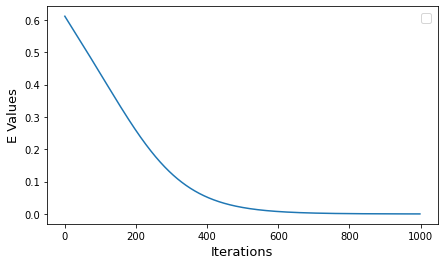

In [25]:
steps = -1
plt.figure(figsize=(7, 4))
plt.plot(eValues[:steps])
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("E Values", fontsize=13)
plt.legend(fontsize=13)
plt.show()

In [23]:
  approximation = state_layer(qnn, symbol_names=params_names, symbol_values=params)
  e = states_distance(approximation,target_state)
  print('params:', params, params% 2*np.pi, 'e:', e)

params: tf.Tensor(
[[5.8125076 3.082775  5.554178  3.536392  8.038719  1.7454691 3.7011755
  0.5023185]], shape=(1, 8), dtype=float32) tf.Tensor(
[[5.694161   3.4016385  4.882595   4.826718   0.12163989 5.483553
  5.3444004  1.5780802 ]], shape=(1, 8), dtype=float32) e: tf.Tensor([[0.6126985]], shape=(1, 1), dtype=float32)
